# 🦸‍♂️ 슈퍼히어로 팀 빌딩 - 범주형 데이터를 활용한 팀 분류 모델 구축하기
---
### 🏰 **배경 스토리:**
당신은 **슈퍼히어로 에이전시**의 데이터 분석가입니다. 에이전시에서는 슈퍼히어로들의 특성과 능력치를 기반으로 팀을 분류하려고 합니다. 
당신의 임무는 **슈퍼히어로 데이터셋을 활용하여 슈퍼히어로를 특정 팀(예: 어벤져스, 저스티스 리그 등)**으로 분류하는 **딥뉴럴넷 모델을 설계하고 학습**시키는 것입니다.

### 📂 **사용 데이터셋:**
- **Superhero Dataset:**
  - 각 슈퍼히어로의 특성(예: Strength, Intelligence, Speed, Agility 등)과 팀 정보가 포함된 CSV 파일
  - 범주형 칼럼: **Team, Alignment, Gender**
  - 연속형 칼럼: **Strength, Intelligence, Speed, Durability, Power, Combat**

### 🎯 **미션 목표:**
1. **데이터 전처리:**
   - 범주형 데이터는 `nn.Embedding`을 활용하여 임베딩 벡터로 변환  
   - 연속형 데이터는 정규화 또는 표준화 적용  
   - 범주형 및 연속형 데이터를 병합하여 최종 입력 데이터셋 구성  

2. **모델 설계:**
   - 입력: 범주형 + 연속형 데이터 병합  
   - 은닉층: `nn.Linear`, `nn.ReLU`, `nn.BatchNorm1d`  
   - 출력층: 분류를 위한 `nn.Softmax` 사용  
   - 모델 구조를 텐서보드에 시각화하기  

3. **모델 학습:**
   - 학습 과정의 Loss 및 Accuracy를 텐서보드로 실시간 시각화  
   - 학습 완료 후, Confusion Matrix를 시각화하여 분류 성능 확인  

4. **결과 분석:**
   - 가장 잘 분류된 슈퍼히어로와 가장 오분류된 슈퍼히어로를 시각화하여 보고  
   - 텐서보드에서 학습 곡선과 임베딩 벡터의 시각화 비교  


🧑‍💻 실습 가이드라인:
1. 데이터셋 준비:
슈퍼히어로 데이터셋을 pandas로 로드하고, 범주형 칼럼들을 astype('category')로 변환

범주형 칼럼의 고유값 수를 기반으로 임베딩 크기 계산

2. 모델 구현:
임베딩 레이어: 각 범주형 칼럼에 대해 임베딩 벡터를 생성

연속형 데이터는 torch.tensor()로 변환하여 병합

은닉층 구성: nn.Linear, nn.ReLU, nn.BatchNorm1d, nn.Dropout

출력층: nn.Softmax로 다중 클래스 분류

3. 텐서보드 시각화:
학습 과정에서 torch.utils.tensorboard를 활용하여 Loss 및 Accuracy 시각화

Confusion Matrix 및 임베딩 벡터 시각화

In [1]:
!pip install torch

In [8]:
!pip install tensorboard
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install seaborn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.1 MB 11.2 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/11.1 MB 11.2 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.1 MB 11.7 MB/s eta 0:00:01
   --------------------------------- ------ 9.2/11.1 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 11.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   -- ------------------------------------- 2.4/41.0 MB 11.2 MB/s eta 0:00:04
   ---- ----------------------------------- 4.7/41.0 MB 11.4 MB/s eta 0:00:04
   ------ --------------------------------- 7.1/41.0 MB 11.5 MB/s eta 0:00:03
   --------- ------------------------------ 9.4/41.0 MB 11.5 MB/s eta 0:00:03
   ----------- ---------------------------- 11.8/41.0 MB 11.5 MB/s eta 0:00:03
   ------------- -------------------------- 14.2/41.0 MB 11.5 MB/s eta 0:00:03

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 텐서보드 설정
writer = SummaryWriter('runs/superhero_classification')


In [10]:
# 데이터셋 경로
dataset_path = 'superhero_dataset.csv'
data = pd.read_csv(dataset_path)
data.head()

,Team,Alignment,Gender,Strength,Intelligence,Speed,Durability,Power,Combat
0,Fantastic Four,Neutral,Male,52,69,86,87,63,82
1,Guardians,Good,Female,35,42,68,87,87,93
2,X-Men,Neutral,Male,61,63,55,27,34,76
3,Guardians,Good,Other,85,57,87,21,70,27
4,Guardians,Evil,Male,74,42,97,60,32,81


In [11]:
categorical_columns = ['Team', 'Alignment', 'Gender']
numerical_columns = ['Strength', 'Intelligence', 'Speed', 'Durability', 'Power', 'Combat']

# 범주형 데이터 라벨 인코딩 및 임베딩 크기 계산
embedding_sizes = []
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    num_classes = len(le.classes_)
    embedding_sizes.append((num_classes, min(50, (num_classes + 1) // 2)))

# 연속형 데이터 표준화
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [12]:
data.head()

,Team,Alignment,Gender,Strength,Intelligence,Speed,Durability,Power,Combat
0,1,2,1,-0.330127,0.467024,1.254639,1.263665,0.157275,0.930797
1,2,1,0,-1.061639,-0.681605,0.456635,1.263665,1.215177,1.412485
2,4,2,1,0.057144,0.211773,-0.119701,-1.478266,-1.121023,0.668058
3,2,1,2,1.089866,-0.043478,1.298973,-1.752460,0.465829,-1.477645
4,2,0,1,0.616535,-0.681605,1.742308,0.029796,-1.209182,0.887007


In [13]:
label_encoders

{'Team': LabelEncoder(), 'Alignment': LabelEncoder(), 'Gender': LabelEncoder()}

In [14]:
class SuperheroNet(nn.Module):
    def __init__(self, embedding_sizes, num_numerical_features, output_dim):
        super(SuperheroNet, self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(num_embeddings, embedding_dim) for num_embeddings, embedding_dim in embedding_sizes])
        self.embedding_dropout = nn.Dropout(0.3)
        self.hidden_layers = nn.Sequential(
            nn.Linear(sum([emb_dim for _, emb_dim in embedding_sizes]) + num_numerical_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x_cat, x_num):
        x_cat = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        x = torch.cat([x_cat, x_num], dim=1)
        x = self.hidden_layers(x)
        return x

In [15]:
# 데이터 분리
X_cat = data[categorical_columns].values
X_num = data[numerical_columns].values
y = data['Team'].values

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat, X_num, y, test_size=0.3, random_state=42
)

# 텐서 변환
X_cat_train = torch.tensor(X_cat_train, dtype=torch.long)
X_num_train = torch.tensor(X_num_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_cat_test = torch.tensor(X_cat_test, dtype=torch.long)
X_num_test = torch.tensor(X_num_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 모델 정의
print('np.unique(y): ', np.unique(y))
output_dim = len(np.unique(y))
print('output_dim: ', output_dim)

model = SuperheroNet(embedding_sizes, len(numerical_columns), output_dim)
print([x for x in model.children()])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_cat_train, X_num_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # 텐서보드에 기록
    writer.add_scalar('Loss/train', loss.item(), epoch)

    # 테스트셋에서의 성능 평가
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_cat_test, X_num_test)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = accuracy_score(y_test, predicted)
        writer.add_scalar('Accuracy/test', accuracy, epoch)

writer.close()
print('학습 완료!')

np.unique(y):  [0 1 2 3 4]
output_dim:  5
[ModuleList(
  (0): Embedding(5, 3)
  (1-2): 2 x Embedding(3, 2)
), Dropout(p=0.3, inplace=False), Sequential(
  (0): Linear(in_features=13, out_features=128, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=128, out_features=5, bias=True)
)]
학습 완료!


test_outputs:  tensor([[ 0.8202,  2.3940,  0.3071, -1.6183, -1.0018],
        [-0.0672, -1.0799,  0.6287,  1.8978,  0.2170],
        [ 2.2316,  0.5777,  1.4286, -1.2181, -1.6652],
        [ 1.8527,  0.6658,  1.7008, -0.6985, -1.3862],
        [ 0.8819,  0.3574,  0.1558, -0.3453, -2.0195],
        [ 1.2258,  0.5045,  1.0568,  0.3035, -1.2233],
        [-0.6511, -2.3324,  0.5805,  2.5656, -0.2592],
        [ 1.1248,  0.6796,  1.0289, -0.4953, -1.7256],
        [ 0.2583,  2.7305,  0.2264, -2.0594, -0.7785],
        [-2.4184, -0.8876, -2.0628, -0.1580,  2.5716],
        [ 0.9765, -0.1983,  1.8982,  0.3544, -1.4208],
        [ 1.8304,  2.8550,  0.5125, -1.8626, -0.6411],
        [ 1.2068,  0.3193,  0.9837, -0.7997, -0.6557],
        [ 0.4433,  0.4542,  0.3547, -0.3335, -2.1178],
        [ 0.9542,  2.5575,  0.0507, -1.6578, -0.5775],
        [ 1.1840,  0.2549,  1.2186, -0.4795, -1.7391],
        [ 2.0399,  0.8570,  2.3059, -0.7336, -0.9000],
        [-1.9054, -1.2707, -1.6826, -0.5332,  2.41

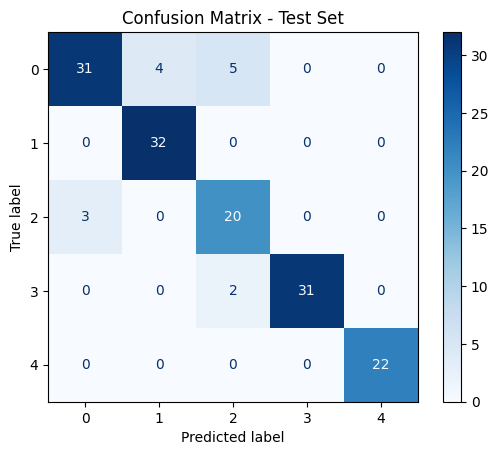

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
with torch.no_grad():
    test_outputs = model(X_cat_test, X_num_test)
    print('test_outputs: ', test_outputs)
    _, predicted = torch.max(test_outputs, 1)
    print('predicted: ', predicted)
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [17]:
# 인터랙티브 입력 기능 구현
def predict_hero(team, alignment, gender, strength, intelligence, speed, durability, power, combat):
    # 입력값 인코딩
    inputs_cat = torch.tensor([
        label_encoders['Team'].transform([team])[0],
        label_encoders['Alignment'].transform([alignment])[0],
        label_encoders['Gender'].transform([gender])[0]
    ]).unsqueeze(0)
    
    inputs_num = torch.tensor([
        strength, intelligence, speed, durability, power, combat
    ]).float().unsqueeze(0)

    model.eval()
    with torch.no_grad():
        output = model(inputs_cat, inputs_num)
        _, predicted = torch.max(output, 1)
        predicted_team = label_encoders['Team'].inverse_transform(predicted.cpu().numpy())
    return predicted_team[0]



# 예시 예측
print(predict_hero('Avengers', 'Good', 'Male', 85, 75, 65, 90, 80, 70))


# 사용자 입력 받기
print("슈퍼히어로의 특성을 입력하세요:")
# team = input("팀: ")
alignment = input("정렬: ")
gender = input("성별: ")
strength = float(input("힘: "))
intelligence = float(input("지능: "))
speed = float(input("속도: "))
durability = float(input("내구성: "))
power = float(input("파워: "))
combat = float(input("전투력: "))

print('Team = ', predict_hero(team, alignment, gender, strength, intelligence, speed, durability, power, combat))

Justice League
슈퍼히어로의 특성을 입력하세요:


ValueError: could not convert string to float: ''

In [18]:
# 잘못 분류된 샘플 시각화
incorrect_indices = (predicted != y_test).nonzero(as_tuple=True)[0]
if len(incorrect_indices) > 0:
    idx = incorrect_indices[0]
    print(f"잘못 분류된 샘플 인덱스: {idx}")
    print(f"실제 팀: {label_encoders['Team'].inverse_transform([y_test[idx].item()])[0]}")
    print(f"예측 팀: {label_encoders['Team'].inverse_transform([predicted[idx].item()])[0]}")
else:
    print("잘못 분류된 샘플이 없습니다.")

잘못 분류된 샘플 인덱스: 5
실제 팀: Guardians
예측 팀: Avengers


선택된 오분류 샘플 인덱스: 5
▶️ 디코딩된 범주형 특성:
   - Team: Guardians
   - Alignment: Good
   - Gender: Female
▶️ 연속형 특성(표준화된 값):
   - Strength: -0.890
   - Intelligence: 0.552
   - Speed: 1.521
   - Durability: -1.798
   - Power: -0.195
   - Combat: 0.011


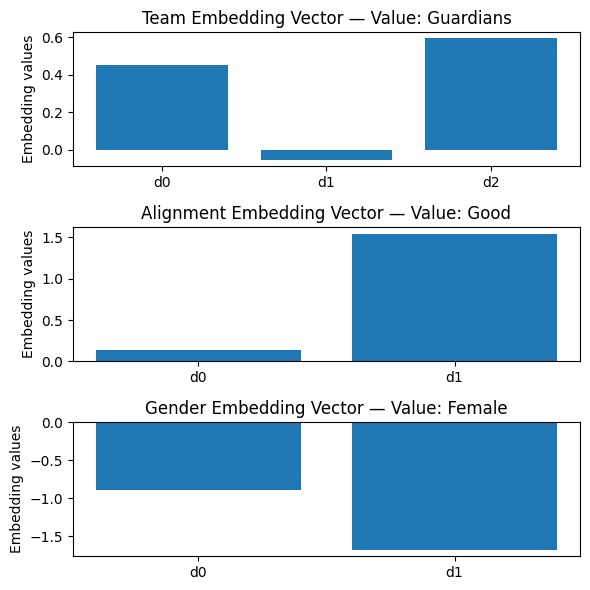

In [19]:
# 1) 테스트셋에서 오분류된 샘플 찾기
model.eval()
with torch.no_grad():
    outputs = model(X_cat_test, X_num_test)
    _, preds = torch.max(outputs, dim=1)

# 오분류된 인덱스 목록
incorrect_idx = (preds != y_test).nonzero(as_tuple=True)[0]
if len(incorrect_idx) == 0:
    print("오분류된 샘플이 없습니다.")
else:
    idx = incorrect_idx[0].item()
    print(f"선택된 오분류 샘플 인덱스: {idx}")

    # 2) 원본 특성 디코딩 및 출력
    cat_vals = X_cat_test[idx].cpu().numpy()
    num_vals = X_num_test[idx].cpu().numpy()

    decoded = {}
    for i, col in enumerate(categorical_columns):
        decoded[col] = label_encoders[col].inverse_transform([cat_vals[i]])[0]
    print("▶️ 디코딩된 범주형 특성:")
    for col, val in decoded.items():
        print(f"   - {col}: {val}")

    print("▶️ 연속형 특성(표준화된 값):")
    for i, col in enumerate(numerical_columns):
        print(f"   - {col}: {num_vals[i]:.3f}")

    # 3) 임베딩 벡터 추출 및 시각화
    import matplotlib.pyplot as plt

    # 각 범주형 변수별 임베딩 벡터 추출
    embeddings = []
    for i, emb_layer in enumerate(model.embeddings):
        # 입력 인덱스 하나를 그대로 넘겨서 (1,)->(1, emb_dim)->(emb_dim,)로
        emb_vec = emb_layer(torch.tensor([cat_vals[i]], device=next(model.parameters()).device))
        embeddings.append(emb_vec.squeeze(0).cpu().detach().numpy())
        

    # 막대그래프로 시각화
    fig, axes = plt.subplots(len(embeddings), 1, figsize=(6, 2*len(embeddings)))
    for i, vec in enumerate(embeddings):
        axes[i].bar(range(len(vec)), vec)
        col = categorical_columns[i]
        axes[i].set_title(f"{col} Embedding Vector — Value: {decoded[col]}")
        axes[i].set_ylabel("Embedding values")
        axes[i].set_xticks(range(len(vec)))
        axes[i].set_xticklabels([f"d{j}" for j in range(len(vec))])
    plt.tight_layout()
    plt.show()
